# Castor analysis

In [239]:
import sys
sys.path.append("/Users/hejajama/lib/")
from matplotlibhelper import *
import matplotlib.pylab as plt
plt.style.use('classic')
import scipy.integrate
import scipy.interpolate
import math

matplotlib.rc('axes.formatter', useoffset=False)

%matplotlib inline

$\newcommand{\der}{\mathrm{d}}$

# Constants and options

Fix constants etc
<br />
<br />
Note that all constants here are in GeV^n

In [180]:
mbgevsqr=2.568
fmgev=5.068
# MVe
sigma02 = 16.36*mbgevsqr

# Minimum bias
minb=0
maxb=99
switch_proton_b=30
bstep=2
bvals=range(minb,switch_proton_b+1,bstep)

R=0.5   # Jet radius

sqrts=5020
if sqrts==5020 or sqrts==7000:
    sigmann=70 * mbgevsqr
    #sigmainel_pA = 2130*mbgevsqr # some glauber estimate
    sigmainel_pA=2061*mbgevsqr # doi.org/10.1016/j.physletb.2016.06.027
elif sqrts==8800:
    sigmann=75*mbgevsqr
elif sqrts==200:
    sigmann=42*mbgevsqr
    
A = 208

sigma_eff = 15*mbgevsqr # sigma_effective in pp DPS
    

energy_bin = 10   #width of the energy bin 
min_energy = 100+energy_bin/2
max_energy = 3500+energy_bin/2

energy_3ps = range(305,min(max_energy,3005), 100)
energy_xvals = range(min_energy,max_energy,int(energy_bin))
energy_dps = range(300+energy_bin/2,min(max_energy,3005),int(energy_bin))

Style parameters

In [128]:
legfont=16
output_dir = "/Users/hejajama/Dropbox/nootit/castor/figs/"
output_dir_paper = "/Users/hejajama/Dropbox/artikkelit/castor_jet/figs/"
lw=1.5 # line width

#datadir="/Users/hejajama/data/castor/p_Pb_sqrts_5020_m_0.2_intpoints_9_lowpt_1_smallstep_smallbin/"
datadir="/Users/hejajama/data/castor/taito/p_Pb_sqrts_5020_m_0.2_lowpt_1.0_intpoints_8_bin_10_smallbin_pt_eta/"
datadir_smallm="/Users/hejajama/data/castor/taito/p_Pb_sqrts_5020_m_0.1_lowpt_1.0_intpoints_8_lowpt_1_smallstep_smallbin_pt_eta/"
datadir_largem="/Users/hejajama/data/castor/taito/p_Pb_sqrts_5020_m_1.0_lowpt_1.0_intpoints_8_smallstep_smallbin_pt_eta//"

datadir_dps="/Users/hejajama/data/castor/taito/p_Pb_dps_sqrts_5020_m_0.2_lowpt_1.0_mcintpoints_5e6_bin_10_eta/"
datadir_3ps = "/Users/hejajama/data/castor/taito/p_Pb_3ps_sqrts_5020_m_0.2_lowpt_1.0_mcintpoints_1e7_bin_10_eta/"

rc("xtick", labelsize=legfont-2)
rc("ytick", labelsize=legfont-2)

# Optical Glauber

In [78]:
def RA(A):
    return fmgev*(1.12*pow(A, 1.0/3.0) - 0.86*pow(A, -1.0/3.0))
def Nbin(b, A):
    return A*TA(b,A)*sigmann
def rho_inel(b, A, sigmann):
    return 1.0 - exp(-A * TA(b,A) * sigmann)

$\int d^2b \rho_\text{inel}(b)$ is normalization constant 
rho_inel is defined in matplotlibhelper as 1.0 - exp(-A * TA(b,A) * sigmann)

In [79]:
def OpticalGlauberNormalization(A):
    normlist = []
    normlist_b = []
    b=minb
    while b<=maxb:
        normlist_b.append(b)
        normlist.append(2.0*pi*b*rho_inel(b, A, sigmann))
        b=b+0.1
    normalization = scipy.integrate.simps(normlist, normlist_b)
    return normalization

First note that contribution at Q_s < Q_s,p is computed in pp collisions and normalized by N_bin, in order to have R_pA contribution 1

In [80]:
#nbin integral for the proton part
def NBin_proton(A):
    nbinvals=[]
    nbinvals_blist=[]
    b=switch_proton_b
    while b<=maxb:
        nbinvals_blist.append(b)
        nbinvals.append(2.0*pi*b*Nbin(b, A))
        b=b+0.1
    if len(nbinvals)==0:
        nbin_proton_coef=0
    else:
        nbin_proton_coef = scipy.integrate.simps(nbinvals, nbinvals_blist)
    return nbin_proton_coef


In [7]:
def AverageNBin(A,bmin,bmax):
    b=bmin
    integrand=[]
    normalization_integrand=[]
    bvals=[]
    while b < bmax:
        integrand.append(2.0*pi*b*Nbin(b,A))
        normalization_integrand.append(2.0*pi*b*rho_inel(b,A,sigmann))
        bvals.append(b)
        b=b+0.1
    
    return scipy.integrate.simps(integrand,bvals)/scipy.integrate.simps(normalization_integrand, bvals)

    

Note: $T_A$ is defined such that $\int d^2 b T_A(b)=1$

In [70]:
def AverageTA(A,bmin,bmax):
    b=bmin
    integrand=[]
    normalization_integrand=[]
    bvals=[]
    while b < bmax:
        integrand.append(2.0*pi*b*TA(b,A))
        normalization_integrand.append(2.0*pi*b*rho_inel(b,A,sigmann))
        bvals.append(b)
        b=b+0.1
    
    return scipy.integrate.simps(integrand,bvals)/scipy.integrate.simps(normalization_integrand, bvals)

    

In [74]:

nuclear_yield_to_xs = 1.0/AverageTA(208,0,99)

$$\int d^2 b (A T_A(b))^2$$

To match calculations where $T_A$ integral is normalized to $A$, approximate result $A^2 / \pi R_A^2$

In [10]:
def Tsqr_with_A_integrate(A):
    # Approx result A*A/(pi*pow(1.13*fmgev,2)*pow(A,2.0/3.0))
    integrand=[]
    bvals=[]
    b=0
    bmax=99
    while b < bmax:
        integrand.append(2.0*pi*b*A*A*pow(TA(b,A),2))
        bvals.append(b)
        b=b+0.1
    
    return  scipy.integrate.simps(integrand,bvals)

In [286]:
Tsqr_with_A_integrate(208)*sigmann*sigmann

398336.17613447091

In [287]:
A*sigmann

37390.08

# Handle files

In [12]:
def ReadExpData(fname):
    evals_exp=[]
    exp_spectra=[]
    binwidth=[]
    pluserr=[]
    minuserr=[]
    tmp=[]
    fname=fname
    readfile_xy(fname,evals_exp, exp_spectra)
    readfile_xy(fname,tmp,  binwidth, ycol=2)
    readfile_xy(fname,minuserr, pluserr, xcol=4, ycol=5)
    
    return [evals_exp, exp_spectra, binwidth, minuserr, pluserr]


In [13]:
def Read_pA_data(datadir):
    # interpolators for every b
    interpolators=[]
    proton_interpolator=False

    xvals=[]
    
    for b in bvals:
        fname = datadir + "pA_b_" + str(b) 

        xdata=[]
        ydata=[]
        tmp=[]
        e2col=[]
        
        try:
            readfile_xy(fname, xdata, ydata,xcol=0, ycol=2)
            readfile_xy(fname, tmp, e2col, ycol=1)
        except IOError:
            sys.stderr.write("ERROR: Nukefile " + fname + " does not exist\n")
            sys.exit(-1)
        except ValueError:
            sys.stderr.write("ERROR: Nukefile " + fname + " is invalid\n")

            
        if e2col[0] - xdata[0] != energy_bin:
            print "ERROR! Bin width parameter is not the same as the bin width in data!"
            print "Parameter " + str(energy_bin) + ", lower " + str(xdata[0]) + " upper " + str(e2col[0])
            print fname
            
        # Shift xdata to bin center
        for i in range(len(xdata)):
            xdata[i] = xdata[i] + energy_bin/2.0
        
        if (b==minb):
            xvals=xdata
        
        #print xdata
        interp=scipy.interpolate.interp1d(xdata, ydata, kind="cubic")

        interpolators.append(interp)           
        
        
        ##### Proton
        
    if float(switch_proton_b) < float(maxb):
        xdata_proton=[]
        ydata_proton=[]
        try:
            readfile_xy(datadir + "pp", xdata_proton, ydata_proton, xcol=0, ycol=2)
        except IOError:
            sys.stderr.write("ERROR: Proton file " + proton_file + " does not exist\n")
            sys.exit(-1)
        except ValueError:
            sys.stderr.write("ERROR: Proton file " + proton_file +" is invalid\n")
            sys.exit(-1)

        for i in range(len(xdata_proton)):
            xdata_proton[i] = xdata_proton[i] + energy_bin/2.0


        try:
            proton_interpolator = scipy.interpolate.interp1d(xdata_proton, ydata_proton, kind="cubic")
        except ValueError:
            sys.stederr.write("ERROR: Too few proton datapoints (" + str(len(ydata)) +"), file " + proton_filename)
            sys.exit(-1)
    
    print "Data " + datadir + " read at energy values "
    print xvals
    
    return [interpolators,proton_interpolator]
        

    
def Read_Ap_data(datadir):
        fname = datadir + "/Ap"
        xdata=[]
        ydata=[]
        readfile_xy(fname, xdata, ydata, ycol=2)
        for i in range(len(xdata)):
            xdata[i] = xdata[i] + energy_bin/2.0
        
        return scipy.interpolate.interp1d(xdata, ydata, kind="cubic")

In [14]:
def Read_xy(fname, xlist, ylist, xcol=0, ycol=1):
    f = open(fname,"r")
    lines=f.readlines()
    n=len(lines)

    for i in range(n):
        s=lines[i].split()
        if s[0][0]!="#":
            xlist.append(float(s[xcol]))
            ylist.append(float(s[ycol]))
    f.close()

# Compute  yield integrating over impact parameter

In [15]:
def Yield(interpolators,proton_interpolator,energyvals):
    invariant_yield=[]
    proton_contribution=[]   # save fractional contribution from pp-like region, for fun
    nbin_A = NBin_proton(A)
    glauber_norm = OpticalGlauberNormalization(A)
    for x in energyvals:

        intvals=[]
        i=0
        for i in range(len(bvals)):
            #try:
            intvals.append(interpolators[i](x)*2.0*pi*bvals[i])
            #except ValueError as detail:
            #    sys.stderr.write("ValueError: x=" + str(x) + "\n")
            #    print detail
            #    sys.exit(1)
            if (interpolators[i](x)*2.0*pi*bvals[i] < 0):
                if interpolators[i](x)*2.0*pi*bvals[i] < -1: #-1e-10:
                    print "#WWWTTTTTTTFFFFFFFFFF, b=" + str(bvals[i]) +" pt " + str(x) + " interp " + str(interpolators[i](x)*2.0*pi*bvals[i])
                    sys.exit(1)
                else:
                    intvals[-1]=0
        bintres = scipy.integrate.simps(intvals, bvals)
        ppres=0
        if float(switch_proton_b) < float(maxb):
            #try:
            ppres = sigma02/sigmann*nbin_A * proton_interpolator(x)
            #except ValueError:
            #    sys.stderr.write("ValueError: x=" + str(x) + "\n")
            #    sys.exit(1)
        res = (bintres + ppres)/glauber_norm
        invariant_yield.append(res)
        proton_contribution.append(ppres/res)
    
    return invariant_yield


# Compute DPS contribution

Idea here is that DPS cross section is
$$\frac{d\sigma^{DPS}}{d[PS]_1 d[PS]_2} = \frac{1}{2} \frac{1}{\sigma_\text{eff}} \frac{d\sigma}{d[PS]_1} \frac{d\sigma}{d[PS]_2} $$ 

<br />

The factor $1/2$ originates as the two jets can not be distinguished (<b>Avoid double counting</b>), see http://iopscience.iop.org/article/10.1088/1742-6596/706/5/052031

We note that cross sections are integrated over azimuth, but the DPS contribution is only seen if the two partons end up in the same jet, in which case azimuthal angles must be close to each other.

Castor note says that
<i>The energy measurement of all channels in a CASTOR sector are summed into a CASTOR tower. These towers are clustered with the anti-kT [28] algorithm with a radius of 0.5 into CASTOR jets, which have their η coordinate is fixed to the geometrical centre of the sector.</i> [https://cds.cern.ch/record/2258273/files/FSQ-17-001-pas.pdf]

We mimic this effect (for now?) by requiring that just azimuthal angle difference is less than $R=0.5$. We assume that double parton distribution function factorizes

<br />
<br />
What is $\sigma_\text{inel}$? In case of $pp$, we can use the experimental value $S_T=\sigma_\text{eff}=15$ mb, which is surprisingly small. 

In case of pA/Ap we fllow https://arxiv.org/pdf/1607.04023.pdf 
<br />
<br />
In pA, we have only "DPS 2" contribution from that Ref, and the DPS contribution is
$$\sigma^\text{DPS}_\text{pA} = \sigma^\text{DPS}_\text{pp} \sigma_\text{eff}^{pp} F_{pA}$$
with the $pp$ DPS cross section and $\sigma_\text{eff}$, and
$$F_{pA} = \frac{A-1}{A} \int d^2 b T_{pA}^2 \approx \frac{ (A-1)A}{\pi R_A^2}$$
where the last approximation is obtained by assuming homogeneous spherical nucleus. Problem here is that no nuclear effects are included...
<br />
<br />
Nulcear effects can be included by replacing the pp cross section by $1/A \times$ pA cross section.
<br />
<br />
In Ap, we have the flux of incoming partons enhanced by A, and the DPS cross section is
$$\sigma^\text{DPS}_\text{Ap} = A \sigma_{pp}^\text{DPS}$$
To take into account nuclear PDF effect, $\sigma_{pp}$ should be computed using nuclear PDFs
<br />
<br />
First, we define here functions to take care of this factorized case (no double parton distribution function)

In [16]:
# cross_section is an interpolator for dsigma/dE
def DPS_cross_section(evals, cross_section, sigmaeff):
    # Only include part of the spectrum where azimuthal angle difference is 0.5
    # This is just a prefactor R/2pi
    
    
    result=[]
    
    
    
    for energy in evals:
    
        minE=min_energy
        maxE=max_energy
        if energy <= minE:
            result.append(0)
            continue


        # now E1+E2=energy
        e1vals=np.linspace(minE,energy,100)
        e2vals=energy-e1vals

        #print e1vals
        #print e2vals

        dpsvals = [cross_section(e1)*cross_section(e2) for e1,e2 in zip(e1vals,e2vals) if e1>minE and e2>minE and e1 < maxE and e2<maxE ]
        evals = [e1 for e1,e2 in zip(e1vals,e2vals) if e1>minE and e2>minE and e1 < maxE and e2<maxE]
        dpsvals = 0.5 * np.array(dpsvals) * R/(2.0*pi)*1.0/sigmaeff 
        
       
        if len(dpsvals)<2:
            result.append(0)
        else:        
            result.append(scipy.integrate.simps(dpsvals,evals))
    return result
    
    
    

In [17]:
# Compute DPS contribution to pA
# pA_cross_section is interpolator, units mb/GeV
# sigmaeff is pp sigma_eff, units mb
def pA_DPS_factorized(evals, pA_cross_section, sigmaeff,A):
    #FpA = (A-1.0)*A/(pi*RA(A)*RA(A))/mbgevsqr
    FpA = (A-1.0)/A * Tsqr_with_A_integrate(A)
    # F_pA is now in 1 / (Gev^(-2)) = GeV^2, convert to 1/mb
    FpA = FpA * mbgevsqr
    # Scale 1/A^2, as we feed in pA cross section which gives two extra powers of A
    dps_to_pA = 1.0/(A*A)*np.array(DPS_cross_section(evals, pA_cross_section, sigmaeff))* FpA * sigmaeff
    return dps_to_pA
 
#In Ap DPS, Ap_cross_section = nPDF * A * pp_cross_section, thus there is no prefactor A, but instead 1/A 
# originating from A * 1/A^2 * (DPS computed using AP interpolator)
def Ap_DPS(evals, Ap_cross_section, sigmaeff,A):
    return  1.0/A * np.array(DPS_cross_section(evals, Ap_cross_section, sigmaeff))

DPS contribution for pA is normalized by this, note that this is significantly larger than $A$, as discussed in the Ref. (=> DPS in pA is enhanced)

In [18]:
(A-1.0)/A * Tsqr_with_A_integrate(A) * sigma_eff

472.55995895073636

### DPS from explicit calculation

We shall mostly use kinematically constrained double parton distribution function which requires us to compute using the C++ code integrla over both pt's and y's. Here we just read the result of this calculation and include proper prefactors.  The code computes
\begin{equation}
\begin{split}
\frac{d N^{DPS}(b_T)}{\Delta E} =    \int d y_1 d y_2 d p_{T,1} d p_{T,2} \theta(E_1 + E_2 \in E, y_1,y_2 \in \text{CASTOR})  \\  
	\times \frac{1}{(2\pi)^4} D_{ij}(x_1,x_2)  S_A(p_{T,1},x_1,b_T) S_A(p_{T,2},x_2,\bt)	
\end{split}
\end{equation}
and we have to add factors
$$\frac{R}{2\pi}\frac{1}{2} \frac{1}{\Delta E}$$
See note for details

In [19]:
def Read_pA_DPS(data, energies):
    [nuke_dps_interpolators,proton_dps_interpolator] = Read_pA_data(data)
    invariant_nuke_dps_yield = Yield(nuke_dps_interpolators, proton_dps_interpolator, energies)

    nuke_dps_cross_section=nuclear_yield_to_xs/energy_bin * np.array(invariant_nuke_dps_yield)

    # Change units to mb, now GeV^(-2)
    scale_list(nuke_dps_cross_section, 1.0/mbgevsqr)
    
    # Azimuthal closeness and double counting
    scale_list(nuke_dps_cross_section, 1.0/2.0 * R/(2.0*pi))
    
    return nuke_dps_cross_section

In [20]:
def Read_pp_DPS(datadir_dps, energies):
    # Read pp DPS xs
    pp_dps_kc_e=[]
    pp_dps_kc_xs=[]
    Read_xy(datadir_dps +"/pp", pp_dps_kc_e, pp_dps_kc_xs, xcol=0, ycol=2)
    for i in range(len(pp_dps_kc_e)):
        pp_dps_kc_e[i] = pp_dps_kc_e[i] +  energy_bin/2.0
    
    # Yiled -> xs, units GeV^-2 -> mb, azimuthal closenss and jet algorithm, normalize bin width
    pp_dps_kc_xs = np.array(pp_dps_kc_xs) * sigma02*sigma02/sigma_eff/mbgevsqr*1.0/2.0*R/(2.0*pi)/energy_bin
    pp_dps_interpolator = scipy.interpolate.interp1d(pp_dps_kc_e, pp_dps_kc_xs, kind="cubic")
    
    return pp_dps_interpolator(energies)

### 3 particle production

\begin{equation}
\begin{split}
\frac{d N^{DPS}(b_T)}{\Delta E} =  \left(\frac{R}{2\pi}\right)^2\frac{1}{3!} \frac{1}{\Delta E}  \int d y_1 d y_2 d y_3 d p_{T,1} d p_{T,2}  d p_{T,3} \theta(E_1 + E_2 + E_3 \in E, y_1,y_2,y_3 \in \text{CASTOR})  \\  
	\times \frac{1}{(2\pi)^6} D_{ijl}(x_1,x_2,x_3)  S_A(p_{T,1},x_1,b_T) S_A(p_{T,2},x_2,b_T) S_A(p_{T,3},x_3,b_T)	
\end{split}
\end{equation}

The C++ code does not include factors $\left(\frac{R}{2\pi}\right)^2\frac{1}{3!} $

In [21]:
def Read_pA_3PS(data, energies):
    [nuke_3ps_interpolators,proton_3ps_interpolator] = Read_pA_data(data)
    invariant_nuke_3ps_yield = Yield(nuke_3ps_interpolators, proton_3ps_interpolator, energies)

    nuke_3ps_cross_section=nuclear_yield_to_xs/energy_bin * np.array(invariant_nuke_3ps_yield)

    # Change units to mb, now GeV^(-2)
    scale_list(nuke_3ps_cross_section, 1.0/mbgevsqr)
    
    # Azimuthal closeness and double counting
    scale_list(nuke_3ps_cross_section, 1.0/(3.0*2.0) * math.pow(R/(2.0*pi), 2.0))
    
    return nuke_3ps_cross_section

## Exponential Ap DPS

Follow https://lib-extopc.kek.jp/preprints/PDF/1988/8812/8812033.pdf but with extra $(R/(2\pi)^{N-1}$ exponent. The resulting spectra which sums 1->inf parton scattering is (<b>I'm not sure about prefactor, should I get some $\sigma_\text{eff}$?)

\begin{equation}
\frac{\der \sigma^\text{jet}}{\der E} = \int \der^2 b \frac{2\pi}{R}  \frac{1}{\sqrt{2\pi \langle E^2 \rangle \frac{R}{2\pi}}} \exp \left[ -\frac{ \left( E - \frac{R}{2\pi} \langle E \rangle \right)^2}{\frac{R}{2\pi} 2\langle E^2 \rangle} \right] \times \exp\left[ - A \sigma_\text{inel} \frac{2\pi-R}{2\pi} \right]    - \sigma_\text{inel} \delta(E)
\end{equation}

Compute nth moment of the cross section, returns
    \begin{equation}
    \langle E^n \rangle = A T_A(b) \int dE \frac{d \sigma}{d E}E^n
    \end{equation}

In [295]:
def SpectraMomenta(n, interp):
    ''' Momenta without A T_A'''
    f=lambda e: interp(e)*pow(e,n)
    
    return scipy.integrate.quad(f,min_energy+energy_bin, max_energy-energy_bin)[0]
    

In [ ]:
def nPS_cross_section_Ap_bintegrand(b,mom1,mom2):
    # Add A T_A factors
    mom1 = mom1*A*TA(b,A)
    mom2 = mom2*A*TA(b,A)
    
    return 1.0/sqrt(2.0*pi*mom2*R/())

In [260]:
def nPS_cross_section_Ap(interp, energies, Rcone=R):
    mom1 = SpectraMomenta(1, interp)/sigmann
    mom2 = SpectraMomenta(2,interp)/sigmann
    
    f=lambda b: TA(b)
    
    result = [sigmann * (2*pi/Rcone) * 1.0/sqrt(Rcone*mom2) * np.exp( -pow(energy - Rcone/(2.0*pi)*mom1, 2.0) / (R/(2.0*pi)*2*mom2)) for energy in energies]
    
    return sigmann*np.array(result)

In [265]:
teste = np.linspace(110,300,10)



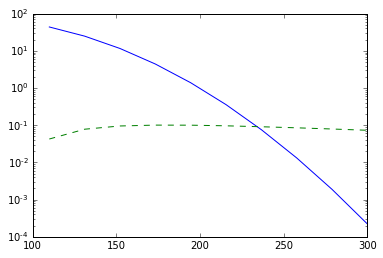

In [279]:
plt.plot(teste,nPS_cross_section_Ap(pp_interpolator, teste, Rcone=2*pi))
#plt.plot(teste,nPS_cross_section_Ap(pp_interpolator, teste, Rcone=0.4), linestyle=Linestyle(2))
plt.plot(teste, pp_interpolator(teste), linestyle=Linestyle(1))
yscale("log")

In [ ]:
plt.plot(teste,nPS_cross_section_Ap(pp_interpolator, teste))
plt.plot(teste, pp_interpolator(teste), linestyle=Linestyle(1))
yscale("log")

# Read in data and initialize interpolators

Note: cross_section lists here are normalized by the bin width! $\Rightarrow$ they are $d\sigma/dE$
<br />
<br />
We initialize interpolators which have units mb/GeV

In [182]:



#yield_to_xs = pi*pow(RA(A),2)
#yield_to_xs = sigmainel_pA
nuclear_yield_to_xs = 1.0/AverageTA(208,0,99)



[nuke_interpolators,proton_interpolator_gev] = Read_pA_data(datadir)
invariant_yield = Yield(nuke_interpolators, proton_interpolator_gev, energy_xvals)


cross_section=nuclear_yield_to_xs/energy_bin * np.array(invariant_yield)
proton_cross_section = sigma02/energy_bin*proton_interpolator_gev(energy_xvals)
proton_invariant_yield = sigma02/sigmann * proton_interpolator_gev(energy_xvals)

# Ap data
Ap_interpolator_in_GeV = Read_Ap_data(datadir)
Ap_yield = sigma02/sigmann*Ap_interpolator_in_GeV(energy_xvals)
Ap_cross_section = sigma02 / energy_bin * Ap_interpolator_in_GeV(energy_xvals)


# Change units to mb, now GeV^(-2)
scale_list(cross_section, 1.0/mbgevsqr)
scale_list(proton_cross_section, 1.0/mbgevsqr)
scale_list(invariant_yield, 1.0/mbgevsqr)
scale_list(proton_invariant_yield, 1.0/mbgevsqr)
scale_list(Ap_yield, 1.0/mbgevsqr)
scale_list(Ap_cross_section, 1.0/mbgevsqr)


pA_interpolator = scipy.interpolate.interp1d(energy_xvals, cross_section, kind="cubic")
Ap_interpolator = scipy.interpolate.interp1d(energy_xvals, Ap_cross_section, kind="cubic")
pp_interpolator = scipy.interpolate.interp1d(energy_xvals, proton_cross_section, kind="cubic")



Data /Users/hejajama/data/castor/taito/p_Pb_sqrts_5020_m_0.2_lowpt_1.0_intpoints_8_bin_10_smallbin_pt_eta/ read at energy values 
[105.0, 115.0, 125.0, 135.0, 145.0, 155.0, 165.0, 175.0, 185.0, 195.0, 205.0, 215.0, 225.0, 235.0, 245.0, 255.0, 265.0, 275.0, 285.0, 295.0, 305.0, 315.0, 325.0, 335.0, 345.0, 355.0, 365.0, 375.0, 385.0, 395.0, 405.0, 415.0, 425.0, 435.0, 445.0, 455.0, 465.0, 475.0, 485.0, 495.0, 505.0, 515.0, 525.0, 535.0, 545.0, 555.0, 565.0, 575.0, 585.0, 595.0, 605.0, 615.0, 625.0, 635.0, 645.0, 655.0, 665.0, 675.0, 685.0, 695.0, 705.0, 715.0, 725.0, 735.0, 745.0, 755.0, 765.0, 775.0, 785.0, 795.0, 805.0, 815.0, 825.0, 835.0, 845.0, 855.0, 865.0, 875.0, 885.0, 895.0, 905.0, 915.0, 925.0, 935.0, 945.0, 955.0, 965.0, 975.0, 985.0, 995.0, 1005.0, 1015.0, 1025.0, 1035.0, 1045.0, 1055.0, 1065.0, 1075.0, 1085.0, 1095.0, 1105.0, 1115.0, 1125.0, 1135.0, 1145.0, 1155.0, 1165.0, 1175.0, 1185.0, 1195.0, 1205.0, 1215.0, 1225.0, 1235.0, 1245.0, 1255.0, 1265.0, 1275.0, 1285.0, 1295.0,

Read low-m and high-m datas for comparison

In [121]:
def Read_large_small_m_interpolators():
    [nuke_interpolators_largem,proton_interpolator_gev_largem] = Read_pA_data(datadir_largem)
    invariant_yield_largem = Yield(nuke_interpolators_largem, proton_interpolator_gev_largem, energy_xvals)
    
    #[nuke_interpolators_smallm,proton_interpolator_gev_smallm] = Read_pA_data(datadir_smallm)
    #invariant_yield_smallm = Yield(nuke_interpolators_smallm, proton_interpolator_gev_smallm, energy_xvals)

    cross_section_largem=nuclear_yield_to_xs/energy_bin * np.array(invariant_yield_largem) / mbgevsqr 
    proton_cross_section_largem = sigma02/energy_bin*proton_interpolator_gev_largem(energy_xvals) / mbgevsqr
    
    #cross_section_smallm=nuclear_yield_to_xs/energy_bin * np.array(invariant_yield_smallm) / mbgevsqr 
    #proton_cross_section_smallm = sigma02/energy_bin*proton_interpolator_gev_smallm(energy_xvals) / mbgevsqr


    # Ap data
    #Ap_interpolator_in_GeV = Read_Ap_data(datadir)
    #Ap_yield = sigma02/sigmann*Ap_interpolator_in_GeV(energy_xvals)
    #Ap_cross_section = sigma02 / energy_bin * Ap_interpolator_in_GeV(energy_xvals)


    pA_interpolator_largem = scipy.interpolate.interp1d(energy_xvals, cross_section_largem, kind="cubic")
    #pA_interpolator_smallm = scipy.interpolate.interp1d(energy_xvals, cross_section_smallm, kind="cubic")
    
    #Ap_interpolator = scipy.interpolate.interp1d(energy_xvals, Ap_cross_section, kind="cubic")
    
    pp_interpolator_largem = scipy.interpolate.interp1d(energy_xvals, proton_cross_section_largem, kind="cubic")
    #pp_interpolator_smallm = scipy.interpolate.interp1d(energy_xvals, proton_cross_section_smallm, kind="cubic")
    
    pA_interpolator_smallm=[]
    pp_interpolator_smallm=[]
    return pA_interpolator_largem, pA_interpolator_smallm, pp_interpolator_largem, pp_interpolator_largem

pA_interpolator_largem, pA_interpolator_smallm, pp_interpolator_largem, pp_interpolator_largem = Read_large_small_m_interpolators()

ERROR! Bin width parameter is not the same as the bin width in data!
Parameter 10, lower 100.0 upper 120.0
/Users/hejajama/data/castor/taito/p_Pb_sqrts_5020_m_1.0_lowpt_1.0_intpoints_8_smallstep_smallbin_pt_eta//pA_b_0
ERROR! Bin width parameter is not the same as the bin width in data!
Parameter 10, lower 100.0 upper 120.0
/Users/hejajama/data/castor/taito/p_Pb_sqrts_5020_m_1.0_lowpt_1.0_intpoints_8_smallstep_smallbin_pt_eta//pA_b_2
ERROR! Bin width parameter is not the same as the bin width in data!
Parameter 10, lower 100.0 upper 120.0
/Users/hejajama/data/castor/taito/p_Pb_sqrts_5020_m_1.0_lowpt_1.0_intpoints_8_smallstep_smallbin_pt_eta//pA_b_4
ERROR! Bin width parameter is not the same as the bin width in data!
Parameter 10, lower 100.0 upper 120.0
/Users/hejajama/data/castor/taito/p_Pb_sqrts_5020_m_1.0_lowpt_1.0_intpoints_8_smallstep_smallbin_pt_eta//pA_b_6
ERROR! Bin width parameter is not the same as the bin width in data!
Parameter 10, lower 100.0 upper 120.0
/Users/hejajama/d

Read DPS/3PS data

In [181]:

# pA DPS
# Note that Read_pA_DPS() returns dsigma/dE in mb/gev
tmp_pA_dps_data = Read_pA_DPS(datadir_dps, energy_dps)
pA_DPS_interpolator = scipy.interpolate.interp1d(energy_dps, tmp_pA_dps_data, kind="cubic")

# pA 3PS
# Again we get directly in GeV/mb
tmp_pA_3ps_data = Read_pA_3PS(datadir_3ps, energy_3ps)
pA_3PS_interpolator =  scipy.interpolate.interp1d(energy_3ps, tmp_pA_3ps_data, kind="cubic")

# read_pp_DPS returns mb/GeV
pp_DPS_interpolator = scipy.interpolate.interp1d(energy_dps, Read_pp_DPS(datadir_dps, energy_dps), kind="cubic")

Data /Users/hejajama/data/castor/taito/p_Pb_dps_sqrts_5020_m_0.2_lowpt_1.0_mcintpoints_5e6_bin_10_eta/ read at energy values 
[305.0, 315.0, 325.0, 335.0, 345.0, 355.0, 365.0, 375.0, 385.0, 395.0, 405.0, 415.0, 425.0, 435.0, 445.0, 455.0, 465.0, 475.0, 485.0, 495.0, 505.0, 515.0, 525.0, 535.0, 545.0, 555.0, 565.0, 575.0, 585.0, 595.0, 605.0, 615.0, 625.0, 635.0, 645.0, 655.0, 665.0, 675.0, 685.0, 695.0, 705.0, 715.0, 725.0, 735.0, 745.0, 755.0, 765.0, 775.0, 785.0, 795.0, 805.0, 815.0, 825.0, 835.0, 845.0, 855.0, 865.0, 875.0, 885.0, 895.0, 905.0, 915.0, 925.0, 935.0, 945.0, 955.0, 965.0, 975.0, 985.0, 995.0, 1005.0, 1015.0, 1025.0, 1035.0, 1045.0, 1055.0, 1065.0, 1075.0, 1085.0, 1095.0, 1105.0, 1115.0, 1125.0, 1135.0, 1145.0, 1155.0, 1165.0, 1175.0, 1185.0, 1195.0, 1205.0, 1215.0, 1225.0, 1235.0, 1245.0, 1255.0, 1265.0, 1275.0, 1285.0, 1295.0, 1305.0, 1315.0, 1325.0, 1335.0, 1345.0, 1355.0, 1365.0, 1375.0, 1385.0, 1395.0, 1405.0, 1415.0, 1425.0, 1435.0, 1445.0, 1455.0, 1465.0, 1475.0,

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


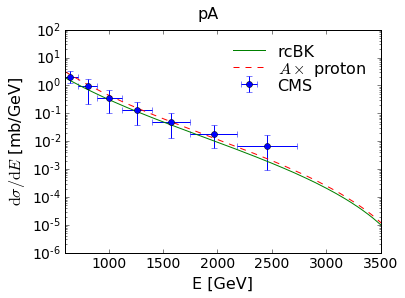

In [25]:
plt.yscale('log')
plt.xlim(xmin=600,xmax=3500)
#plt.ylim(ymin=1e-3)

plt.xlabel("E [GeV]",fontsize=legfont)
plt.ylabel("$\mathrm{d}\sigma/\mathrm{d}E$ [mb/GeV]", fontsize=legfont)

# Exp data
evals_exp=[]
exp_spectra=[]
binwidth=[]
pluserr=[]
minuserr=[]
[evals_exp, exp_spectra, binwidth, minuserr, pluserr] = ReadExpData("/Users/hejajama/data/castor/exp/pA_spectra_w_errors.txt")
plt.errorbar(evals_exp, exp_spectra, xerr=binwidth, yerr=[minuserr,pluserr], marker=datadashes[1], 
             linestyle='None', label="CMS")


# Theory
plt.plot(energy_xvals,cross_section, label="rcBK")


plt.plot(energy_xvals, 208*np.array(proton_cross_section), label=r"$A\times$ proton", linestyle=Linestyle(1))

plt.suptitle("pA", fontsize=legfont)
leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
leg.draw_frame(False)
plt.gcf().subplots_adjust(left=0.17)

savefig(output_dir+"pA_spectra.pdf")

## Compare SPS with Hannu

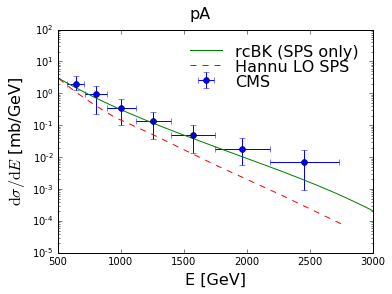

In [294]:
def CompareSPS_with_Hannu():
    plt.yscale('log')
    plt.xlim(xmin=500,xmax=3000)
    #plt.ylim(ymin=1e-3)

    plt.xlabel("E [GeV]",fontsize=legfont)
    plt.ylabel("$\mathrm{d}\sigma/\mathrm{d}E$ [mb/GeV]", fontsize=legfont)

    # Exp data
    evals_exp=[]
    exp_spectra=[]
    binwidth=[]
    pluserr=[]
    minuserr=[]
    [evals_exp, exp_spectra, binwidth, minuserr, pluserr] = ReadExpData("/Users/hejajama/data/castor/exp/pA_spectra_w_errors.txt")
    plt.errorbar(evals_exp, exp_spectra, xerr=binwidth, yerr=[minuserr,pluserr], marker=datadashes[1], 
                 linestyle='None', label="CMS")


    # Theory
    plt.plot(energy_xvals,cross_section, label="rcBK (SPS only)")

    # Hannu
    xdata=[]
    ydata=[]
    readfile_xy("/Users/hejajama/data/castor/hannu/lo_sps_p_Pb_y_5.2_6.6", xdata,ydata, xcol=0, ycol=2)
    tmp=[]
    xdata2=[]
    readfile_xy("/Users/hejajama/data/castor/hannu/lo_sps_p_Pb_y_5.2_6.6", xdata2,tmp, xcol=1, ycol=2)
    for i in range(len(xdata)):
        xdata[i] = (xdata[i] + xdata2[i])/2.0
    
    plt.plot(xdata, ydata, label="Hannu LO SPS", linestyle=Linestyle(1))
    plt.suptitle("pA", fontsize=legfont)
    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
    leg.draw_frame(False)
    plt.gcf().subplots_adjust(left=0.17)

    savefig(output_dir+"hannu_comparison.pdf")

CompareSPS_with_Hannu()

# Include DPS

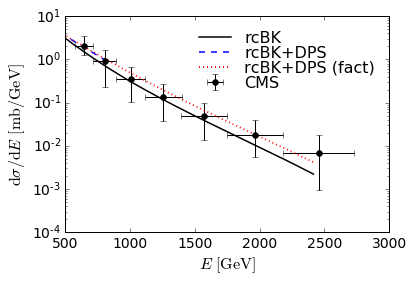

In [154]:
 def Plot_pA_spectra_w_wo_DPS():
    plt.yscale('log')
    plt.xlim(xmin=500,xmax=3000)
    plt.ylim(ymin=1e-4)

    plt.xlabel("$E\ [\mathrm{GeV}]$",fontsize=legfont)
    plt.ylabel("$\mathrm{d}\sigma/\mathrm{d}E$ $[\mathrm{mb}/\mathrm{GeV}]$", fontsize=legfont)

    # Exp data
    [evals_exp, exp_spectra, binwidth, minuserr, pluserr] = ReadExpData("/Users/hejajama/data/castor/exp/pA_spectra_w_errors.txt")
    plt.errorbar(evals_exp, exp_spectra, xerr=binwidth, yerr=[minuserr,pluserr], marker=datadashes[1], 
                 linestyle='None', label="CMS", color=Color(0))



    pA_cross_section=pA_interpolator(energy_xvals)

    # Theory
    # Add DPS
    dps_to_pA = pA_DPS_factorized(energy_xvals, pA_interpolator, sigma_eff/mbgevsqr, A)
    plt.plot(energy_xvals,np.array(pA_cross_section), label="rcBK", linestyle=Linestyle(0), color=Color(0), linewidth=lw)
   

    # Add DPS with DPDF
    totxs_w_dps = np.array(pA_interpolator(energy_dps)) + np.array(pA_DPS_interpolator(energy_dps))
    plt.plot(energy_dps, totxs_w_dps, linestyle=Linestyle(1), linewidth=lw, color=Color(1), label="rcBK+DPS")
    
    # DPS w/o kic
    plt.plot(energy_xvals,np.array(pA_cross_section)+np.array(dps_to_pA), label="rcBK+DPS (fact)", linestyle=Linestyle(2), color=Color(2), linewidth=lw+0.3)
    
    #plt.suptitle("pA", fontsize=legfont)

    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
    leg.draw_frame(False)
    plt.gcf().subplots_adjust(left=0.15)
    plt.gcf().subplots_adjust(bottom=0.15)

    #savefig(output_dir+"pA_spectra_with_dps.pdf")
    #savefig(output_dir_paper+"pA_spectra_with_dps.pdf")

Plot_pA_spectra_w_wo_DPS()

# Relative improtrance of DPS: compute DPS/Single

pA

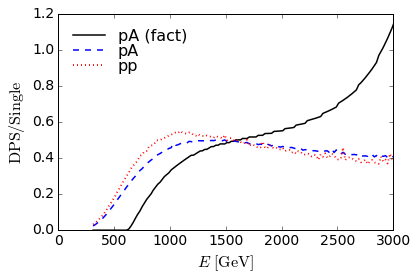

In [27]:
ratio_factorized_pA = pA_DPS_factorized(energy_xvals, pA_interpolator, sigma_eff/mbgevsqr, A) / pA_interpolator(energy_xvals)
ratio_pA = pA_DPS_interpolator(energy_dps) / pA_interpolator(energy_dps)
ratio_pp =  pp_DPS_interpolator(energy_dps) / pp_interpolator(energy_dps)
#ratio_Ap = Ap_DPS(energy_xvals, Ap_interpolator, sigma_eff/mbgevsqr, A) / Ap_interpolator(energy_xvals)
#ratio_pp = DPS_cross_section(energy_xvals, pp_interpolator, sigma_eff/mbgevsqr) / pp_interpolator(energy_xvals)


plt.plot(energy_xvals, ratio_factorized_pA, linestyle=Linestyle(0), label="pA (fact)", linewidth=lw, color=Color(0))
plt.plot(energy_dps, ratio_pA, linestyle=Linestyle(1), label="pA", linewidth=lw, color=Color(1))
plt.plot(energy_dps, ratio_pp, label="pp", linestyle=Linestyle(2), color=Color(2), linewidth=lw+0.3)

plt.ylabel("$\mathrm{DPS}/\mathrm{Single}$", fontsize=legfont)
plt.xlabel("$E\ [\mathrm{GeV}]$", fontsize=legfont)
plt.ylim(ymax=1.2)
plt.xlim(xmax=3000)
leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=2)
leg.draw_frame(False)
plt.gcf().subplots_adjust(bottom=0.15)
savefig(output_dir + "dps_single_ratio_pA.pdf")
#plt.yscale("log")

pp

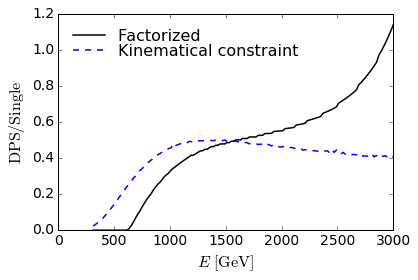

In [28]:
ratio_factorized_pp = np.array(DPS_cross_section(energy_xvals, pp_interpolator, sigma_eff/mbgevsqr)) / pp_interpolator(energy_xvals)
ratio_pp =  pp_DPS_interpolator(energy_dps) / pp_interpolator(energy_dps)
#ratio_Ap = Ap_DPS(energy_xvals, Ap_interpolator, sigma_eff/mbgevsqr, A) / Ap_interpolator(energy_xvals)
#ratio_pp = DPS_cross_section(energy_xvals, pp_interpolator, sigma_eff/mbgevsqr) / pp_interpolator(energy_xvals)


plt.plot(energy_xvals, ratio_factorized_pA, linestyle=Linestyle(0), label="Factorized", linewidth=lw, color=Color(0))
plt.plot(energy_dps, ratio_pA, linestyle=Linestyle(1), label="Kinematical constraint", linewidth=lw, color=Color(1))
#plt.plot(energy_xvals, ratio_Ap, label="Ap", linestyle=Linestyle(2))

plt.ylabel("$\mathrm{DPS}/\mathrm{Single}$", fontsize=legfont)
plt.xlabel("$E\ [\mathrm{GeV}]$", fontsize=legfont)
plt.ylim(ymax=1.2)
plt.xlim(xmax=3000)
leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=2)
leg.draw_frame(False)
plt.gcf().subplots_adjust(bottom=0.15)
#savefig(output_dir + "dps_single_ratio_pA.pdf")
#plt.yscale("log")

# 3 parton scattering

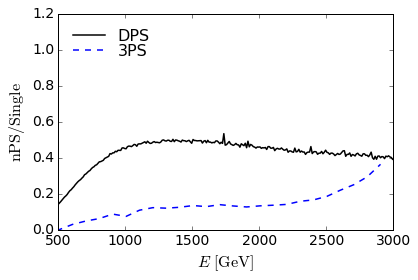

In [183]:
def Compare_2_3_PS():
    ratio_pA_DPS = pA_DPS_interpolator(energy_dps) / pA_interpolator(energy_dps)
    ratio_pA_3PS = pA_3PS_interpolator(energy_3ps) / pA_interpolator(energy_3ps)
    
    plt.plot(energy_dps, ratio_pA_DPS, linestyle=Linestyle(0), label="DPS", linewidth=lw, color=Color(0))
    plt.plot(energy_3ps, ratio_pA_3PS, linestyle=Linestyle(1), label="3PS", linewidth=lw, color=Color(1))

    plt.ylabel("$\mathrm{nPS}/\mathrm{Single}$", fontsize=legfont)
    plt.xlabel("$E\ [\mathrm{GeV}]$", fontsize=legfont)
    plt.ylim(ymax=1.2)
    plt.xlim(xmax=3000,xmin=500)
    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=2)
    leg.draw_frame(False)
    
    #plt.suptitle("pA", fontsize=legfont)
    plt.gcf().subplots_adjust(bottom=0.15)
    
    #savefig(output_dir + "/dps_3ps_single_ratio_pA.pdf")
    #savefig(output_dir_paper + "/dps_3ps_single_ratio_pA.pdf")
Compare_2_3_PS()

# Ap spectra

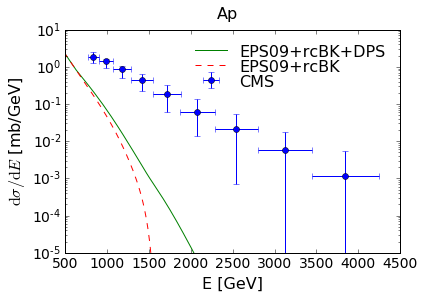

In [30]:
Ap_spectra_with_dps = Ap_interpolator(energy_xvals) + Ap_DPS(energy_xvals, Ap_interpolator, sigma_eff/mbgevsqr,A)

### data
[evals_exp, exp_spectra, binwidth, minuserr, pluserr] = ReadExpData("/Users/hejajama/data/castor/exp/Ap_spectra_w_errors.txt")
plt.errorbar(evals_exp, exp_spectra, xerr=binwidth, yerr=[minuserr,pluserr], marker=datadashes[1], 
             linestyle='None', label="CMS")

plt.xlabel("E [GeV]",fontsize=legfont)
plt.ylabel("$\mathrm{d}\sigma/\mathrm{d}E$ [mb/GeV]", fontsize=legfont)


plt.plot(energy_xvals, Ap_spectra_with_dps, label="EPS09+rcBK+DPS")
plt.plot(energy_xvals, Ap_interpolator(energy_xvals), label="EPS09+rcBK", linestyle=Linestyle(1))

plt.yscale("log")
plt.ylim(ymin=1e-5)
plt.xlim(xmin=500)

plt.suptitle("Ap", fontsize=legfont)


leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
leg.draw_frame(False)
savefig(output_dir+"spectra_Ap.pdf")

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.


Text(0.5,0.98,u'Ap')

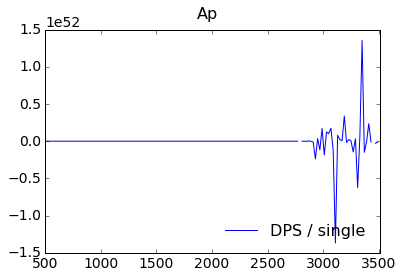

In [31]:
dps_ratio_Ap=Ap_DPS(energy_xvals, Ap_interpolator, sigma_eff/mbgevsqr,A) / Ap_interpolator(energy_xvals)
plt.xlim(xmin=500,xmax=max_energy)
#plt.ylim(ymax=1, ymin=0.01)
#plt.yscale("log")
plt.plot(energy_xvals, dps_ratio_Ap, label="DPS / single")
leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=4)
leg.draw_frame(False)
plt.suptitle("Ap", fontsize=legfont)

# Ratio to data

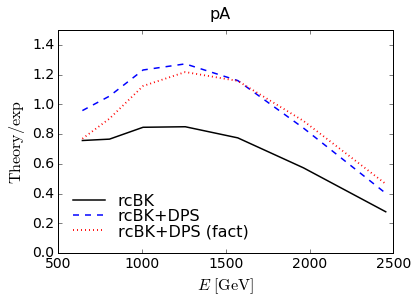

In [32]:
def CompareData():
    # Read pA data
    [evals_exp, exp_spectra, binwidth, minuserr, pluserr] = ReadExpData("/Users/hejajama/data/castor/exp/pA_spectra_w_errors.txt")

    theoryvals=pA_interpolator(evals_exp)
    theoryvals_w_dps=np.array(theoryvals)+pA_DPS_factorized(evals_exp, pA_interpolator, sigma_eff/mbgevsqr, A)
    ratiovals = [th/exp for th,exp in zip(theoryvals,exp_spectra)]
    ratiovals_w_dps = [th/exp for th,exp in zip(theoryvals_w_dps,exp_spectra)]

    plt.plot(evals_exp, ratiovals, label="rcBK", linestyle=Linestyle(0),color=Color(0), linewidth=lw)
   
    
    # Add DPDF
    evals_exp_for_dpdf = [e for e in evals_exp if e <= energy_dps[-1]]
    #dps_with_dpdf = Read_pA_DPS(datadir_dps, evals_exp_for_dpdf)
    totxs_w_dps = np.array(pA_interpolator(evals_exp_for_dpdf)) + np.array(pA_DPS_interpolator(evals_exp_for_dpdf))
    ratiovals_w_dpdf = [th/exp for th,exp in zip(totxs_w_dps, exp_spectra)]
    plt.plot(evals_exp_for_dpdf, ratiovals_w_dpdf, linestyle=Linestyle(1), color=Color(1), label="rcBK+DPS", linewidth=lw)
    
    # factorized
    plt.plot(evals_exp, ratiovals_w_dps, label="rcBK+DPS (fact)", linestyle=Linestyle(2), color=Color(2), linewidth=lw+0.3)
    
    #plt.yscale('log')
    plt.ylabel("$\mathrm{Theory}/\mathrm{exp}$", fontsize=legfont)
    plt.xlabel("$E\ [\mathrm{GeV}]$", fontsize=legfont)
    plt.xlim(xmin=500,xmax=2500)
    plt.ylim(ymin=0.0, ymax=1.5)
    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=3)
    leg.draw_frame(False)

    plt.suptitle("pA", fontsize=legfont)

    
    savefig(output_dir+"pA_theory_exp_ratio.pdf")
    
CompareData()

# PlotRpA

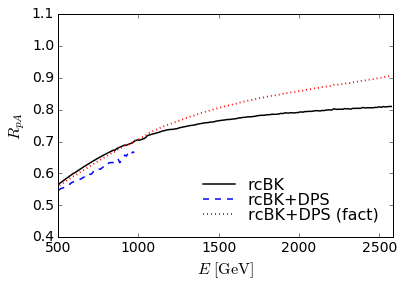

In [166]:
def ComputeRpA():
    rpa_evals=[x for x in energy_xvals]
    rpa=[pA_interpolator(e)/(A*pp_interpolator(e)) for e in rpa_evals if pp_interpolator(e)>0]
    rpa_evals=[ene for ene in rpa_evals if pp_interpolator(ene)>0]

    rpa_with_dps = [pA/(A*pp) for pA,pp in zip( 
        np.array(pA_interpolator(rpa_evals)) + pA_DPS_factorized(rpa_evals, pA_interpolator, sigma_eff/mbgevsqr, A), 
        np.array(pp_interpolator(rpa_evals)) + np.array(DPS_cross_section(rpa_evals, pp_interpolator, sigma_eff/mbgevsqr)))]

    plt.plot(rpa_evals, rpa, label=r"rcBK", color=Color(0), linewidth=lw)
    


    # With DPDF
    
    #pp_dps_interpolator = scipy.interpolate.interp1d(energy_dps, Read_pp_DPS(datadir_dps, energy_dps), kind="cubic")

    #dps_with_dpdf = Read_pA_DPS(datadir_dps, energy_dps)
    totxs_w_dps = np.array(pA_interpolator(energy_dps)) + np.array(pA_DPS_interpolator(energy_dps))
    proton_xs_dps = np.array(pp_interpolator(energy_dps)) + np.array(pp_DPS_interpolator(energy_dps))
    ratio_w_dpdf = [pA/(A*pp) for pA,pp in zip(totxs_w_dps, proton_xs_dps)]
    
    plt.plot(energy_dps, ratio_w_dpdf, label="rcBK+DPS", linestyle=Linestyle(1), color=Color(1), linewidth=lw)
    
    
    #
    plt.plot(rpa_evals, rpa_with_dps, label=r"rcBK+DPS (fact)", linestyle=Linestyle(2), linewidth=lw+0.3, color=Color(2))

    plt.xlabel("$E\ [\mathrm{GeV}]$",fontsize=legfont)
    plt.ylabel(r"$R_{pA}$",fontsize=legfont)
    plt.ylim(ymax=1.1)
    plt.xlim(xmin=500,xmax=max_energy)
    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=4)
    leg.draw_frame(False)

    #savefig(output_dir+"rpa.pdf")
    #savefig(output_dir_paper + "rpa.pdf")
    
ComputeRpA()

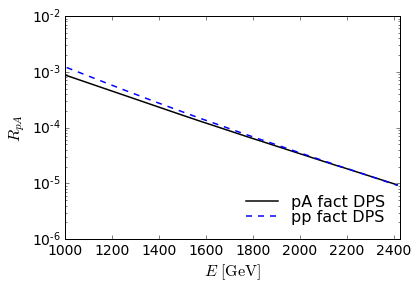

In [156]:
def pA_vs_pp_with_DPS():
   
   

    pA_w_dps =  0*np.array(pA_interpolator(energy_xvals)) + np.array(pA_DPS_factorized(energy_xvals, pA_interpolator, sigma_eff/mbgevsqr, 208))
    pp_w_fact_dps = 0*np.array(pp_interpolator(energy_xvals)) + np.array(DPS_cross_section(energy_xvals, pp_interpolator, sigma_eff/mbgevsqr))

    scale_list(pA_w_dps, 1.0/A)
    
    plt.plot(energy_xvals, pA_w_dps, label=r"pA fact DPS", color=Color(0), linewidth=lw)
    plt.plot(energy_xvals, pp_w_fact_dps, label=r"pp fact DPS", color=Color(1), linestyle=Linestyle(1), linewidth=lw)

    
   # for pa,pp in zip(pA_w_dps, pp_w_fact_dps):
    #    print pa/pp

    # With DPDF
    
    #pp_dps_interpolator = scipy.interpolate.interp1d(energy_dps, Read_pp_DPS(datadir_dps, energy_dps), kind="cubic")

    #dps_with_dpdf = Read_pA_DPS(datadir_dps, energy_dps)
    #totxs_w_dps = np.array(pA_interpolator(energy_dps)) + np.array(pA_DPS_interpolator(energy_dps))
    #proton_xs_dps = np.array(pp_interpolator(energy_dps)) + np.array(pp_dps_interpolator(energy_dps))
    #ratio_w_dpdf = [pA/(A*pp) for pA,pp in zip(totxs_w_dps, proton_xs_dps)]
    
    #plt.plot(energy_dps, ratio_w_dpdf, label="rcBK+DPS w DPDF", linestyle=Linestyle(1), color=Color(1), linewidth=lw)
    
    
    #
   # plt.plot(rpa_evals, rpa_with_dps, label=r"rcBK + DPS (fact)", linestyle=Linestyle(2), linewidth=lw+0.3, color=Color(2))

    plt.xlabel("$E\ [\mathrm{GeV}]$",fontsize=legfont)
    plt.ylabel(r"$R_{pA}$",fontsize=legfont)
    #plt.ylim(ymax=1.2)
    yscale("log")
    plt.xlim(xmin=1000,xmax=max_energy)
    #plt.ylim(ymin=1e-7, ymax=1e-4)
    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=4)
    leg.draw_frame(False)

    #savefig(output_dir+"rpa.pdf")
    
pA_vs_pp_with_DPS()

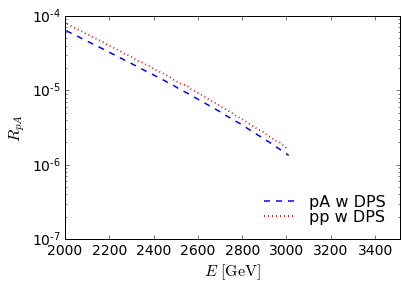

In [35]:
def pA_vs_pp_with_nofactor_DPS():
   
   

    

    # With DPDF
    
    #pp_dps_interpolator = scipy.interpolate.interp1d(energy_dps, Read_pp_DPS(datadir_dps, energy_dps), kind="cubic")

    #dps_with_dpdf = Read_pA_DPS(datadir_dps, energy_dps)
    totxs_w_dps = np.array(pA_interpolator(energy_dps)) + np.array(pA_DPS_interpolator(energy_dps))
    proton_xs_dps = np.array(pp_interpolator(energy_dps)) + np.array(pp_DPS_interpolator(energy_dps))
    
    scale_list(totxs_w_dps, 1.0/A)
    
    plt.plot(energy_dps, totxs_w_dps, label="pA w DPS", linestyle=Linestyle(1), color=Color(1), linewidth=lw)
    plt.plot(energy_dps, proton_xs_dps, label=r"pp w DPS", linestyle=Linestyle(2), linewidth=lw+0.3, color=Color(2))

    plt.xlabel("$E\ [\mathrm{GeV}]$",fontsize=legfont)
    plt.ylabel(r"$R_{pA}$",fontsize=legfont)
    #plt.ylim(ymax=1.2)
    yscale("log")
    plt.xlim(xmin=2000,xmax=max_energy)
    plt.ylim(ymin=1e-7, ymax=1e-4)
    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=4)
    leg.draw_frame(False)

    
pA_vs_pp_with_nofactor_DPS()

# pA / Ap ratio

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.


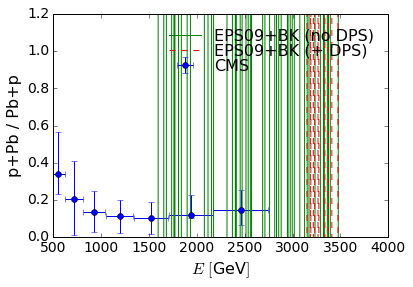

In [36]:
theory_pA_Ap_ratio = [pA_interpolator(e) / Ap_interpolator(e) for e in energy_xvals]

theory_pA_Ap_ratio_w_dps = [pA/Ap for pA,Ap in zip( 
    np.array(pA_interpolator(energy_xvals))+pA_DPS_factorized(energy_xvals, pA_interpolator, sigma_eff/mbgevsqr, A), 
    Ap_interpolator(energy_xvals) + Ap_DPS(energy_xvals, Ap_interpolator, sigma_eff/mbgevsqr, A))]

# Read data
[evals_exp, pA_Ap_ratio, binwidth, minuserr, pluserr] = ReadExpData("/Users/hejajama/data/castor/exp/pA_Ap_w_errors.txt")
plt.errorbar(evals_exp, pA_Ap_ratio, xerr=binwidth, yerr=[minuserr,pluserr], marker=datadashes[1], 
             linestyle='None', label="CMS")

plt.plot(energy_xvals, np.array(theory_pA_Ap_ratio), label="EPS09+BK (no DPS)")
plt.plot(energy_xvals, theory_pA_Ap_ratio_w_dps, label="EPS09+BK (+ DPS)", linestyle=Linestyle(1))



plt.ylabel("p+Pb / Pb+p", fontsize=legfont)
plt.xlabel("$E$ $[$GeV$]$", fontsize=legfont)
plt.ylim(ymax=1.2,ymin=0)
plt.xlim(xmin=500)
leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
leg.draw_frame(False)

savefig(output_dir + "pA_Ap_ratio.pdf")

# DPS comparison

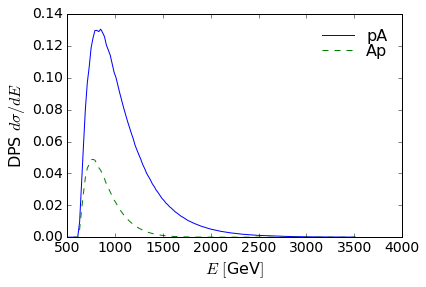

In [37]:
plt.plot(energy_xvals,pA_DPS_factorized(energy_xvals, pA_interpolator, sigma_eff/mbgevsqr,A), label="pA")
plt.plot(energy_xvals,Ap_DPS(energy_xvals, Ap_interpolator, sigma_eff/mbgevsqr,A), label="Ap", linestyle=Linestyle(1))

plt.ylabel("DPS $d\sigma/dE$", fontsize=legfont)
plt.xlabel("$E$ $[$GeV$]$", fontsize=legfont)
#plt.ylim(ymax=1.2,ymin=0)
plt.xlim(xmin=500)
leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
leg.draw_frame(False)
#plt.yscale("log")

savefig(output_dir + "pA_Ap_ratio.pdf")

For comparison yields

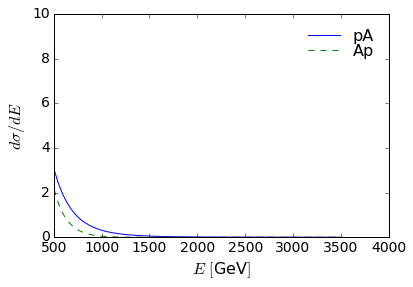

In [38]:
plt.plot(energy_xvals,pA_interpolator(energy_xvals), label="pA")
plt.plot(energy_xvals,Ap_interpolator(energy_xvals), label="Ap", linestyle=Linestyle(1))

plt.ylabel("$d\sigma/dE$", fontsize=legfont)
plt.xlabel("$E$ $[$GeV$]$", fontsize=legfont)
#plt.ylim(ymax=1.2,ymin=0)
plt.xlim(xmin=500)
plt.ylim(ymax=10)
leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
leg.draw_frame(False)
#plt.yscale("log")


# pp DPS comparisons

<b>NOTE:</b> when comparing with factorized result, note that there we include only the phase space where the second jet has energy > min_energy. E.g. we start from 100 GeV E, then the factorized result at 300GeV does not contain kinematics [250,50], but the full result does. Thus, we should only trust the factorized result at energies >> low_cutoff, which in this case is:

In [104]:
print "Minimum energy included in factorized DPS calculation: " + str(energy_xvals[0])

Minimum energy included in factorized DPS calculation: 105


Text(0.5,0.98,u'pp')

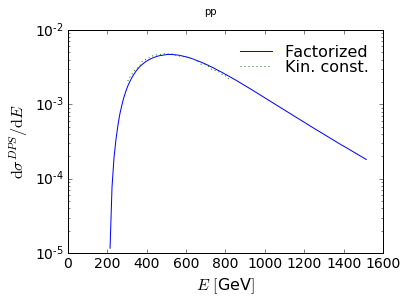

In [132]:
pp_dps_xs = DPS_cross_section(energy_xvals, pp_interpolator, sigma_eff/mbgevsqr)

    
pp_dps_kinc_interpolator = scipy.interpolate.interp1d(energy_dps, Read_pp_DPS(datadir_dps, energy_dps), kind="cubic")

dps_kinc_xs = pp_dps_kinc_interpolator(energy_dps)

plt.plot(energy_xvals, pp_dps_xs, label="Factorized")
plt.plot(energy_dps, dps_kinc_xs, label="Kin. const.", linestyle=Linestyle(2))

#plt.xlim(xmin=300,xmax=3000)
plt.yscale("log")

leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
leg.draw_frame(False)

plt.ylabel(r"$\mathrm{d}\sigma^{DPS}/\mathrm{d}E$", fontsize=legfont)
plt.xlabel("$E$ $[$GeV$]$", fontsize=legfont)

plt.gcf().subplots_adjust(left=0.17)
plt.suptitle("pp")

#savefig(output_dir + "dps_pp_dpdf.pdf")

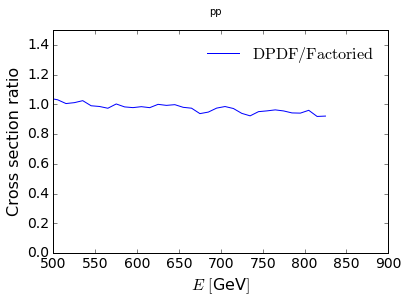

In [134]:
def Plot_DPS_kinc_effect_in_pp():
    pp_dps_interpolator = scipy.interpolate.interp1d(energy_dps, Read_pp_DPS(datadir_dps, energy_dps), kind="cubic")
    ratios=[]
    energies=[]
    for energy in energy_dps:
        factxs = DPS_cross_section([energy], pp_interpolator, sigma_eff/mbgevsqr)[0] 
        if factxs > 0:
            ratios.append( pp_dps_interpolator(energy) / factxs)
            energies.append(energy)
        
    #kin_constraint_energies=[e for e,e2,fact in zip(dps_e,dps_kinc_e,dps_xs) if fact>0]
    #factorized_pp_dps_xs = DPS_cross_section(kin_constraint_energies, pp_interpolator, sigma_eff/mbgevsqr)
    #kin_constraint_effect=[constraint/fact for constraint,fact in zip(dps_kinc_xs, factorized_pp_dps_xs) if fact>0]

    
    plt.plot(energies,ratios,label="$\mathrm{DPDF}/\mathrm{Factoried}$")
    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
    leg.draw_frame(False)
    suptitle("pp")
    plt.ylabel("Cross section ratio", fontsize=legfont)
    plt.xlabel("$E$ $[$GeV$]$", fontsize=legfont)
    plt.ylim(ymin=0,ymax=1.5)
    plt.xlim(xmin=500)
    #savefig("/Users/hejajama/Dropbox/nootit/castor/figs/dps_factorized_dpdf_in_pp.pdf")
    
Plot_DPS_kinc_effect_in_pp()

index 53 is out of bounds for axis 0 with size 53 1370.0
index 54 is out of bounds for axis 0 with size 53 1390.0
index 55 is out of bounds for axis 0 with size 53 1410.0
index 56 is out of bounds for axis 0 with size 53 1430.0
index 57 is out of bounds for axis 0 with size 53 1450.0
index 58 is out of bounds for axis 0 with size 53 1470.0
index 59 is out of bounds for axis 0 with size 53 1490.0
index 60 is out of bounds for axis 0 with size 53 1510.0
A value in x_new is above the interpolation range. 1530.0
A value in x_new is above the interpolation range. 1550.0
A value in x_new is above the interpolation range. 1570.0
A value in x_new is above the interpolation range. 1590.0
A value in x_new is above the interpolation range. 1610.0
A value in x_new is above the interpolation range. 1630.0
A value in x_new is above the interpolation range. 1650.0
A value in x_new is above the interpolation range. 1670.0
A value in x_new is above the interpolation range. 1690.0
A value in x_new is ab

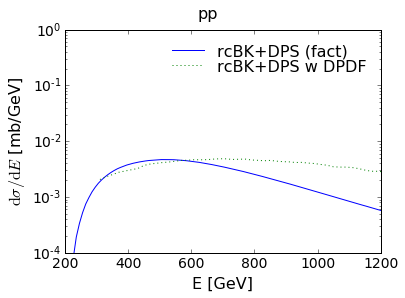

In [135]:
 def Plot_pp_spectra_w_wo_DPS():
    plt.yscale('log')
    plt.xlim(xmin=200,xmax=1200)
    plt.ylim(ymin=1e-4, ymax=1)
    #plt.ylim(ymin=1e-6, ymax=1e-1)

    plt.xlabel("E [GeV]",fontsize=legfont)
    plt.ylabel("$\mathrm{d}\sigma/\mathrm{d}E$ [mb/GeV]", fontsize=legfont)


    pp_cross_section=pp_interpolator(energy_xvals)

    # Theory
    # Add DPS
    dps_to_pp = DPS_cross_section(energy_xvals, pp_interpolator, sigma_eff/mbgevsqr)
    
    #plt.plot(energy_xvals,np.array(pp_cross_section), label="rcBK", linestyle=Linestyle(1))
    plt.plot(energy_xvals,np.array(0*pp_interpolator(energy_xvals))+np.array(dps_to_pp), label="rcBK+DPS (fact)")

    # Add DPS with DPDF
    totxs_w_dps = [] #np.array(pp_interpolator(dps_kinc_e) + np.array(dps_kinc_xs))
    for e in dps_kinc_e:
        try:
            totxs_w_dps.append(0*pp_interpolator(e) + dps_kinc_xs[dps_kinc_e.index(e)])
        except Exception, ee:
            print ee, e
            totxs_w_dps.append(0)
    plt.plot(dps_kinc_e, totxs_w_dps, linestyle=Linestyle(2), label="rcBK+DPS w DPDF")
    
    plt.suptitle("pp", fontsize=legfont)

    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
    leg.draw_frame(False)
    plt.gcf().subplots_adjust(left=0.17)

    #savefig(output_dir+"pp_spectra_w_wo_dps.pdf")

Plot_pp_spectra_w_wo_DPS()

In [42]:


def TestProtonDPS():
    dps_kinc_e=[]
    dps_kinc_xs=[]
    Read_xy(datadir_dps + "/pp", dps_kinc_e, dps_kinc_xs, xcol=0, ycol=2)
    dps_interp = scipy.interpolate.interp1d(dps_kinc_e, dps_kinc_xs, kind="cubic")
    dps_kinc_xs = dps_interp(energy_dps)

    factorized_dps_xs = DPS_cross_section(energy_dps, pp_interpolator, sigma_eff/mbgevsqr)
    dps_kinc_xs = np.array(dps_kinc_xs) * sigma02*sigma02/sigma_eff/mbgevsqr*1.0/2.0*R/(2.0*pi)/energy_bin

    plt.plot(energy_dps, 0*pp_interpolator(energy_dps) + np.array(factorized_dps_xs), label="rcBK + DPS fact")
    plt.plot(energy_dps, 0*pp_interpolator(energy_dps) + np.array(dps_kinc_xs), label="rcBK + DPS w DPDF")
    
    
    #plt.plot(dps_e, dps_xs, label="MC 5e5", linestyle=Linestyle(1))
    #plt.plot(dps_kinc_e, dps_kinc_xs, label="MC 5e5 kin. const.", linestyle=Linestyle(2))

    plt.xlim(xmin=200,xmax=3000)
    plt.yscale("log")

    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
    leg.draw_frame(False)

    plt.ylabel(r"$\mathrm{d}\sigma^{DPS}/\mathrm{d}E$", fontsize=legfont)
    plt.xlabel("$E$ $[$GeV$]$", fontsize=legfont)

    plt.gcf().subplots_adjust(left=0.17)

    #savefig(output_dir + "dps_pp_dpdf.pdf")
TestProtonDPS()

ValueError: A value in x_new is above the interpolation range.

# m dependence

In [ ]:
 def Plot_pA_spectra_mdep():
    plt.yscale('log')
    plt.xlim(xmin=500,xmax=2600)
    plt.ylim(ymin=1e-3)

    plt.xlabel("$E\ [\mathrm{GeV}]$",fontsize=legfont)
    plt.ylabel("$\mathrm{d}\sigma/\mathrm{d}E$ $[\mathrm{mb}/\mathrm{GeV}]$", fontsize=legfont)

    # Exp data
    [evals_exp, exp_spectra, binwidth, minuserr, pluserr] = ReadExpData("/Users/hejajama/data/castor/exp/pA_spectra_w_errors.txt")
    plt.errorbar(evals_exp, exp_spectra, xerr=binwidth, yerr=[minuserr,pluserr], marker=datadashes[1], 
                 linestyle='None', label="CMS", color=Color(0))



    pA_cross_section_smallm=pA_interpolator_smallm(energy_xvals)
    pA_cross_section_largem=pA_interpolator_largem(energy_xvals)
    
    plt.plot(energy_xvals, pA_cross_section_smallm, label="small $m$", linestyle=Linestyle(0), color=Color(0), linewidth=lw)
    plt.plot(energy_xvals, pA_cross_section_largem, label="large $m$", linestyle=Linestyle(1), color=Color(1), linewidth=lw)

    

    # Add DPS with DPDF
    #totxs_w_dps = np.array(pA_interpolator(energy_dps)) + np.array(pA_DPS_interpolator(energy_dps))
    #plt.plot(energy_dps, totxs_w_dps, linestyle=Linestyle(1), linewidth=lw, color=Color(1), label="rcBK+DPS")
    
   
    plt.suptitle("pA", fontsize=legfont)

    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
    leg.draw_frame(False)
    plt.gcf().subplots_adjust(left=0.15)
    plt.gcf().subplots_adjust(bottom=0.15)

    #savefig(output_dir+"pA_spectra_with_dps.pdf")

Plot_pA_spectra_mdep()

ValueError: A value in x_new is above the interpolation range.

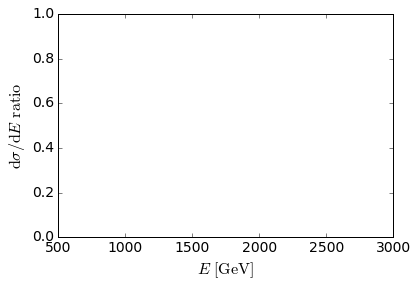

In [167]:
 def Plot_pA_spectra_ratio_mdep():
    #plt.yscale('log')
    plt.xlim(xmin=500,xmax=3000)
    #plt.ylim(ymin=1e-3)

    plt.xlabel("$E\ [\mathrm{GeV}]$",fontsize=legfont)
    plt.ylabel("$\mathrm{d}\sigma/\mathrm{d}E$ $\mathrm{ratio}$", fontsize=legfont)

   

    #pA_cross_section_smallm=pA_interpolator_smallm(energy_xvals)
    pA_cross_section_largem=pA_interpolator_largem(energy_xvals)
    
    ratio = [large/std for large,std in zip(pA_cross_section_largem,pA_interpolator(energy_xvals))]
    
    plt.plot(energy_xvals, ratio, label="$m=1\ \mathrm{GeV}/m=0.2\ \mathrm{GeV}$", linestyle=Linestyle(0), color=Color(0), linewidth=lw)
    
    

    # Add DPS with DPDF
    #totxs_w_dps = np.array(pA_interpolator(energy_dps)) + np.array(pA_DPS_interpolator(energy_dps))
    #plt.plot(energy_dps, totxs_w_dps, linestyle=Linestyle(1), linewidth=lw, color=Color(1), label="rcBK+DPS")
    
   
    plt.suptitle("pA", fontsize=legfont)

    leg=legend(prop=dict(size=legfont),labelspacing=0.001,ncol=1,numpoints=1, loc=1)
    leg.draw_frame(False)
    plt.gcf().subplots_adjust(left=0.15)
    plt.gcf().subplots_adjust(bottom=0.15)

    savefig(output_dir+"pA_spectra_mdep.pdf")

Plot_pA_spectra_ratio_mdep()